ResNet32 On CIFAR-10을 학습하고 나서 논문에서 MultiStepLR로 epoch 30, 60, 90 설정했다는 것을 깨달음
* Image preprocessing 방법 변경
* lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1, verbose=True)

# Training details

- The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation [41].
- A 224×224 crop is randomly sampled from an image or its
- horizontal flip, with the per-pixel mean subtracted [21].
- The standard color augmentation in [21] is used. 
- We adopt batch normalization (BN) [16] right after each convolution and before activation, following [16]. 
- We initialize the weights as in [13] and train all plain/residual nets from scratch. 
- We use SGD with a mini-batch size of 256. 
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus,
and the models are trained for up to 60 × 104 iterations. 
- We use a weight decay of 0.0001 and a momentum of 0.9.
- We do not use dropout

- training details
- randomly sample 224×224 crops for data augmentation.
- We use a mini-batch size of 256 images for fine-tuning
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
- We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
- We initialize the learning rate for the pre-trained network to be 0.01

In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import os
from torch.utils.data import random_split

from urllib.request import urlretrieve
import json

import matplotlib.pyplot as plt
import PIL

2024-01-23 08:09:27.634120: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 08:09:27.809637: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Load ImageNet

In [29]:
# X The image is resized with its shorter side randomly sampled in [256, 480] for scale augmentation [41].
# V A 224×224 crop is randomly sampled from an image or its horizontal flip, 
# V with the per-pixel mean subtracted [21].
# V The standard color augmentation in [21] is used. (Fancy PCA)
# - We adopt batch normalization (BN) [16] right after each convolution and before activation, following [16]. 
# - We initialize the weights as in [13] and train all plain/residual nets from scratch. 
# - We use SGD with a mini-batch size of 256. 
# - The learning rate starts from 0.1 and is divided by 10 when the error plateaus,
# and the models are trained for up to 60 × 10^4 iterations. 
# - We use a weight decay of 0.0001 and a momentum of 0.9.
# - We do not use dropout

# https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# make squre size image with shorter side randomly sampled in [256, 480]
def shorter_side_resize(img):
    w, h = img.size
    if w < h:
        new_w = torch.randint(256, 480, (1,)).item()
        new_h = int(new_w)
    else:
        new_h = torch.randint(256, 480, (1,)).item()
        new_w = int(new_h)
    return transforms.Resize((new_h, new_w))(img)

trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([   
        shorter_side_resize,
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])   
)

valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        # transforms.Resize(size=256),
        transforms.Resize(size=(256 + 480) // 2),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize,
    ])
)

In [30]:
mini_batch_size = 256

num_threads =torch.get_num_threads()
print('num_threads: ', num_threads)

# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=num_threads, pin_memory=True
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=num_threads, pin_memory=True
)

num_threads:  8


In [31]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

mini_batch_size : 256
# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

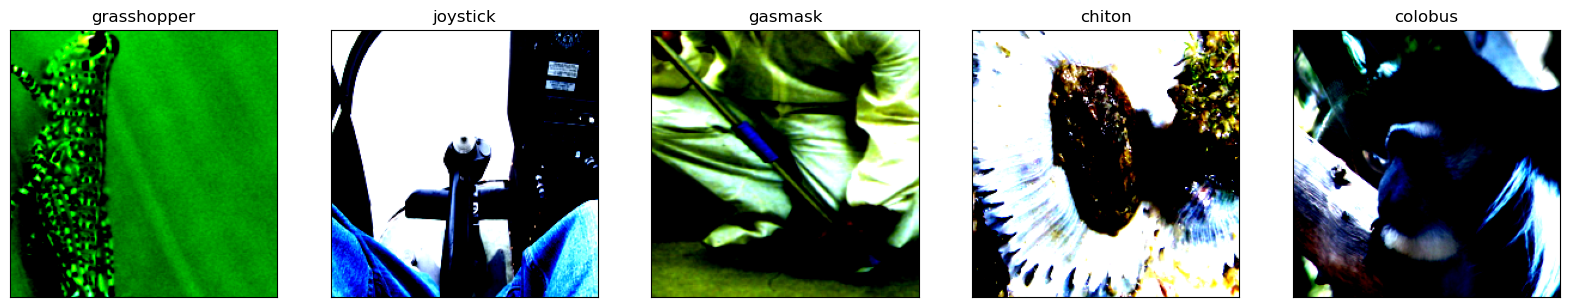

In [32]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)

writer = SummaryWriter('../runs/my_resnet34_exp2')

# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    print(f"{image.size()}")

# modeling ResNet34 by myself

* paper_resnet34 architecture : 
   - 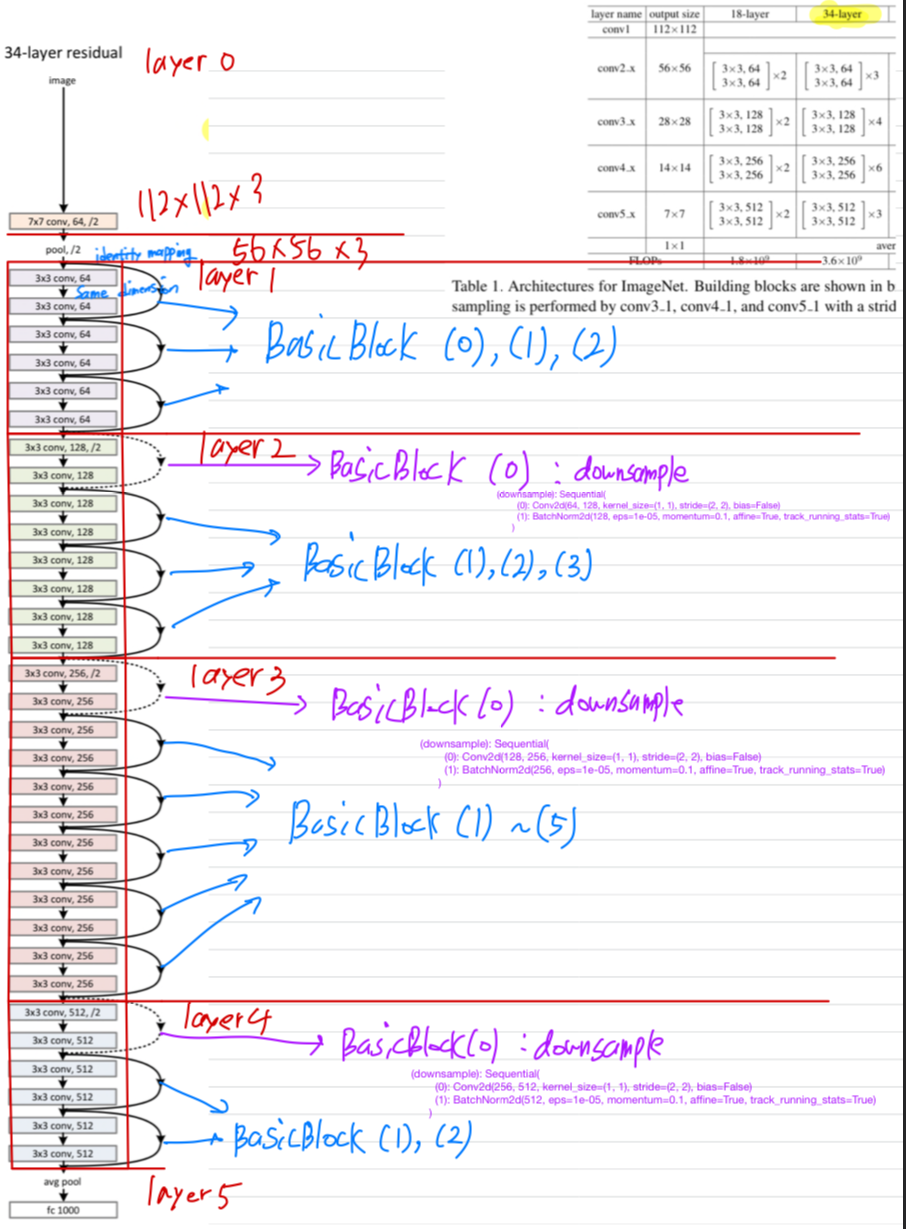
   - 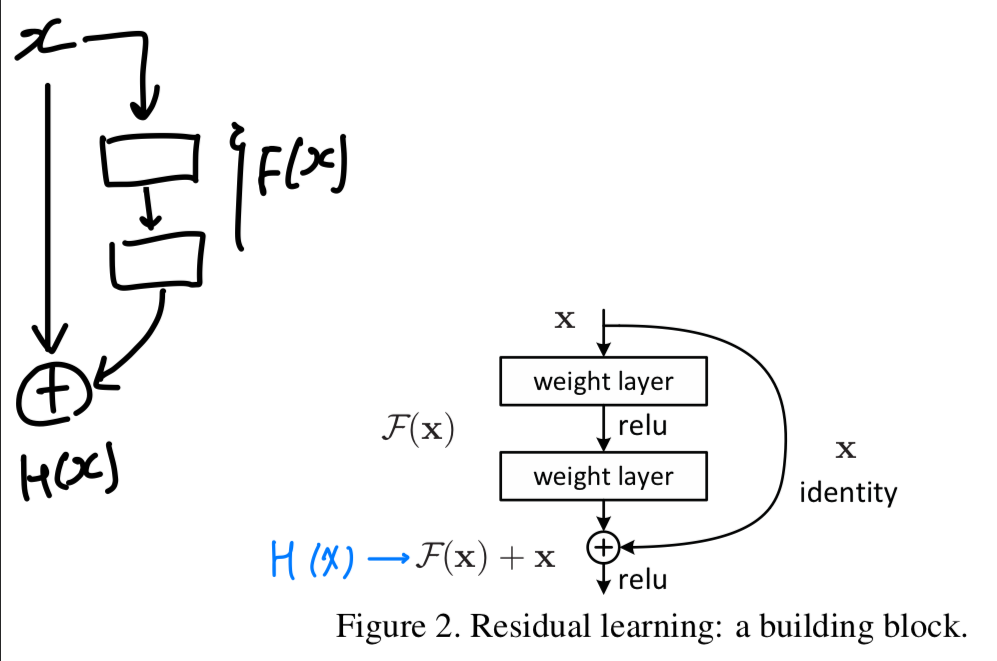


In [2]:
class BuildingBlock(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = 1      # In block without down_sampling, stride is 1.
        self.kernel_size = 3 # In block without down_sampling, kernel_size is 3.
        self.padding = 1
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
    
    def forward(self, x) : 
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity # identity mapping
        out = self.relu2(out)
        
        return out

In [3]:
class BuildingBlockWithDownSample(nn.Module) :
    def __init__(self, in_channels, out_channels) :
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = 3
        self.down_sampling_kernel_size = 1
        self.conv1_stride = 2 # In block with down_sampling, conv1's stride is 2.
        self.conv2_stride = 1 # In block with down_sampling, conv2's stride is 1.
        self.padding = 1

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv1_stride, padding=self.padding, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, stride=self.conv2_stride, padding=self.padding, bias=False) 
        self.bn2 = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        # (projection shortcut) : H, W of activation map are down_sampled, C of activation map is up_sampled
        self.downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.down_sampling_kernel_size, stride=self.conv1_stride, padding=0, bias=False),
            nn.BatchNorm2d(out_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        )
    
    def forward(self, x) : 
        identity = self.downsample(x) # projection shortcut 
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        out += identity       # projection shortcut
        out = self.relu2(out) # block output
        
        return out
        
        

In [4]:
# Class ResNet34 > Class BuildingBlock, Class BuildingBlockWithDownSample
class MyResNet34(nn.Module) :
    def __init__(self) :
        super().__init__()
        num_classes : int = 1000
        
        self.layer0 = nn.Sequential( # 2
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), # affine : True ? gamma, beta, track_running_stats : True ? running_mean, running_var
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = nn.Sequential( # 3 * 2 = 6
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
            BuildingBlock(64, 64), # identity mapping
        )
        self.layer2 = nn.Sequential( # 4 * 2 = 8
            BuildingBlockWithDownSample(64, 128), # projection shortcut
            BuildingBlock(128, 128), # identity mapping
            BuildingBlock(128, 128), # identity mapping
            BuildingBlock(128, 128), # identity mapping
        )
        self.layer3 = nn.Sequential( # 5 * 2 = 10
            BuildingBlockWithDownSample(128, 256), # projection shortcut
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
            BuildingBlock(256, 256),
        )
        self.layer4 = nn.Sequential( # 3 * 2 = 6
            BuildingBlockWithDownSample(256, 512), # projection shortcut
            BuildingBlock(512, 512),
            BuildingBlock(512, 512),
        )
        self.layer5 = nn.Sequential( # 2
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes, bias=True),
        )
        
    def forward(self, x) : 
        ## Input size : 224 x 224 x 3 -> 112 x 112 x 64 -> Output size : 56 x 56 x 64
        x = self.layer0(x)
        ## Input size : 56 x 56 x 64, Output size : 56 x 56 x 64
        x = self.layer1(x)
        ## Input size : 56 x 56 x 64, Output size : 28 x 28 x 128
        x = self.layer2(x)
        ## Input size : 28 x 28 x 128, Output size : 7 x 7 x 512
        x = self.layer3(x)
        ## Input size : 7 x 7 x 512, Output size : 1 x 1 x 512
        x = self.layer4(x)
        ## Input size : (mini_batch_size) x 1 x 1 x 512 ->  1 x 1 x 512 -> Output size : 1 x 1 x 1000
        x = self.layer5(x)
        
        return x        
        

In [36]:
# training details
## randomly sample 224×224 crops for data augmentation.
## We use a mini-batch size of 256 images for fine-tuning
## The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
## We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
## We initialize the learning rate for the pre-trained network to be 0.01
model = MyResNet34()
print(model.eval)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# he initialization, not use bias
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.Conv2d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
    elif type(m) == nn.BatchNorm2d:
        m.weight.data.fill_(1)

model.apply(init_weights)

<bound method Module.eval of MyResNet34(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=

MyResNet34(
  (layer0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
    )
    (1): BuildingBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=T

In [37]:
# hyper parameters
## learning rate
lr = 0.1
## momentum
momentum = 0.9
## weight decay
L2 = 0.0001
# the number of iterations at 1 epoch
num_iters = (len(trainset) // mini_batch_size) + 1
# the number of epochs
epochs = 120
print(f"num_iters at 1 epoch: {num_iters}")
total_num_iters = num_iters * epochs
print(f"total num_iters: {total_num_iters}")

## optimizer
## scheduler
## loss function
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=L2)        

## if val loss plateaus, lr decay
# lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.01)  # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.1, verbose=True) # https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.MultiStepLR.html

num_iters at 1 epoch: 5005
total num_iters: 600600
Adjusting learning rate of group 0 to 1.0000e-01.


In [38]:
# check # of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"# of total parameters : {total_params}")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"# of trainable parameters : {total_trainable_params}")

# of total parameters : 21797672
# of trainable parameters : 21797672


In [39]:
# record model to tensorboard
# Assuming 'device' is defined as torch.device("cuda") or "cuda:0"
input_tensor = trainset[0][0].unsqueeze(0).to(device)
writer.add_graph(model, input_tensor)

In [40]:
# for visualization, record training loss and val loss
train_loss_list = []
val_loss_list = []

# accuracy
val_acc_list = []

In [41]:
import time
# Start measuring time
start_time = time.time()

# ------------------------------------------------------------------------------------------------------------------------------

# training no pretrained resnet34 model with GPU
for epoch in range(0, epochs):
    model.train().to(device) 
    running_loss = 0.0
    print(f"{epoch+1} / {epochs} epoch ----------------------------------------")
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # every 1,000 iteration
        running_loss += loss.item()
        if i % 1000 == 999:
            print(f"[{epoch+1}, {i+1}th iteration] loss : {running_loss / 1000}")
            writer.add_scalar('training loss', running_loss / 1000, epoch * num_iters + i)
            running_loss = 0.0
            
    # every epoch
    # validation loss, accuracy
    val_loss = 0.0
    correct = 0
    total = 0
    model.eval().to(device)
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    print(f"val loss : {val_loss / num_val_batch}")
    print(f"val acc : {100. * correct / total}")
    writer.add_scalar('validation loss', val_loss / num_val_batch, epoch+1)
    writer.add_scalar('validation acc', 100. * correct / total, epoch+1)
    writer.flush()
    
    lr_scheduler.step()
    writer.add_scalar('learning rate', optimizer.param_groups[0]['lr'], epoch+1)
    val_loss_list.append(val_loss / num_val_batch)
    val_acc_list.append(100. * correct / total)
    
    # save best model (minimum val loss)
    if val_loss / num_val_batch == min(val_loss_list):
        PATH = f"./My_ResNet34_exp2_Checkpoint/best_model.pth"
        torch.save(model.state_dict(), PATH)
            
    # every 5th epoch, save model
    if (epoch+1) % 5 == 0:
        PATH = f"./My_ResNet34_exp2_Checkpoint/epoch_{epoch+1}.pth"
        torch.save(model.state_dict(), PATH)
    
    
# ------------------------------------------------------------------------------- -----------------------------------------------        
        
# End measuring time
end_time = time.time()

# Calculate and print the training time
training_time = end_time - start_time
print(f"Training time: {training_time:.2f} seconds")

1 / 120 epoch ----------------------------------------
[1, 1000th iteration] loss : 6.492999106884002
[1, 2000th iteration] loss : 5.570096920967102
[1, 3000th iteration] loss : 4.988336734294891
[1, 4000th iteration] loss : 4.52732288312912
[1, 5000th iteration] loss : 4.169868484735489
val loss : 4.727219671619181
val acc : 13.094
Adjusting learning rate of group 0 to 1.0000e-01.
2 / 120 epoch ----------------------------------------
[2, 1000th iteration] loss : 3.88433918261528
[2, 2000th iteration] loss : 3.663204700469971
[2, 3000th iteration] loss : 3.4917595155239107
[2, 4000th iteration] loss : 3.358790222644806
[2, 5000th iteration] loss : 3.2746305503845217
val loss : 3.4124686839629192
val acc : 28.806
Adjusting learning rate of group 0 to 1.0000e-01.
3 / 120 epoch ----------------------------------------
[3, 1000th iteration] loss : 3.107025166273117
[3, 2000th iteration] loss : 3.0493743319511415
[3, 3000th iteration] loss : 2.9896222138404847
[3, 4000th iteration] loss : 

: 

# In Paper, top-1 error., top-5 error. (10-crop testing)
- `top-1 acc.` : 75.48 %
- `top-5 acc.` : 92.54 %

## exp1 : transforms.Resize(256),

In [6]:
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        # 10-crop
        transforms.Resize(256), # exp1
        # transforms.Resize((256 + 480) // 2), # exp2
        transforms.TenCrop(224),    
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [7]:
mini_batch_size = 64

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=8, pin_memory=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)
print(f"num_val_batch : {num_val_batch}")

num_val_batch : 782


In [8]:
# best model에 대한 top-1 accuracy 계산
model = MyResNet34()
model.load_state_dict(torch.load("./My_ResNet34_exp2_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 0.9642751472228018
val acc : 75.266%
error rate : 24.734%


In [13]:
# best model에 대한 top-5 accuracy 계산, TenCrop
model = MyResNet34()
model.load_state_dict(torch.load("./My_ResNet34_exp2_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.topk(5, 1, True, True)
        total += target.size(0)
        correct += predicted.eq(target.view(-1, 1).expand_as(predicted)).sum().item()     

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.11852025909497
val acc : 91.678%
error rate : 8.322%


: 

## exp 2 : transforms.Resize((256 + 480) // 2),

In [8]:
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val',
    transform=transforms.Compose([
        # 10-crop
        # transforms.Resize(256),
        transforms.Resize(368),
        transforms.TenCrop(224),    
        transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [9]:
mini_batch_size = 64

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=8, pin_memory=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)
print(f"num_val_batch : {num_val_batch}")

num_val_batch : 782


In [10]:
# best model에 대한 top-1 accuracy 계산
model = MyResNet34()
model.load_state_dict(torch.load("./My_ResNet34_exp2_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.118583918913551
val acc : 73.006%
error rate : 26.994%


In [11]:
# best model에 대한 top-5 accuracy 계산, TenCrop
model = MyResNet34()
model.load_state_dict(torch.load("./My_ResNet34_exp2_Checkpoint/best_model.pth"))

val_loss = 0.0
correct = 0
total = 0
model.eval().to(device)
with torch.no_grad():
    for batch in val_loader:
        input, target = batch
        input, target = input.to(device), target.to(device)
        bs, ncrops, c, h, w = input.size()
        result = model(input.view(-1, c, h, w))
        result_avg = result.view(bs, ncrops, -1).mean(1)
        loss = criterion(result_avg, target)
        
        val_loss += loss.item()
        _, predicted = result_avg.topk(5, 1, True, True)
        total += target.size(0)
        correct += predicted.eq(target.view(-1, 1).expand_as(predicted)).sum().item()     

print(f"val loss : {val_loss / num_val_batch}")
print(f"val acc : {100. * correct / total}%")
print(f"error rate : {100. * (total - correct) / total}%")

val loss : 1.1185165493537093
val acc : 91.678%
error rate : 8.322%


: 